In [1]:
import algorithms as alg
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [2]:
from functions import *

In [3]:
from algorithms import *

In [4]:
from utils import *

# Logistic regression

## heart

In [5]:
%%time
dataset = "heart"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  270 , dimension of the problem:  13
Smoothness constant of the sum:  26710.680138975204
Average smoothness constant   :  27147.725435185188
Worst smoothness constant     :  90369.64000000001
Fraction of non-zero elemenst :  0.750997150997151
Wall time: 4.99 ms


### Find the solution

In [6]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [7]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.34746070201411655
      fun: 0.34746070201411655
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.18022874e-04, -4.92434147e-05, -5.73365962e-05,  6.30103350e-05,
        1.45951382e-03,  2.04549402e-05,  8.52075196e-06,  6.36357072e-04,
       -1.09125613e-04,  4.75894375e-05,  7.78891542e-05, -7.50183576e-05,
        1.07577141e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 515
      nit: 424
   status: 0
  success: True
        x: array([-0.05426514,  1.08297105,  0.47963534,  0.01434477,  0.00491626,
       -0.53545124,  0.30627334, -0.04035967,  0.7519325 ,  0.36852213,
        0.12257487,  1.15561376,  0.34995591])
Wall time: 127 ms


In [ ]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [8]:
l2 = 0
l1 = 0
sparse = False
sparse_full = False


bs = 10

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 0.5
x_init[0:num_of_non_zeros] += shift_param
N = 10000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-8
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  13.239656660526755


# Tests

### ARDFDS_E

In [ ]:
%%time
tuning_stepsize_param_options_ardfds_e = [0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
for step_param in tuning_stepsize_param_options_ardfds_e:
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
                        f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

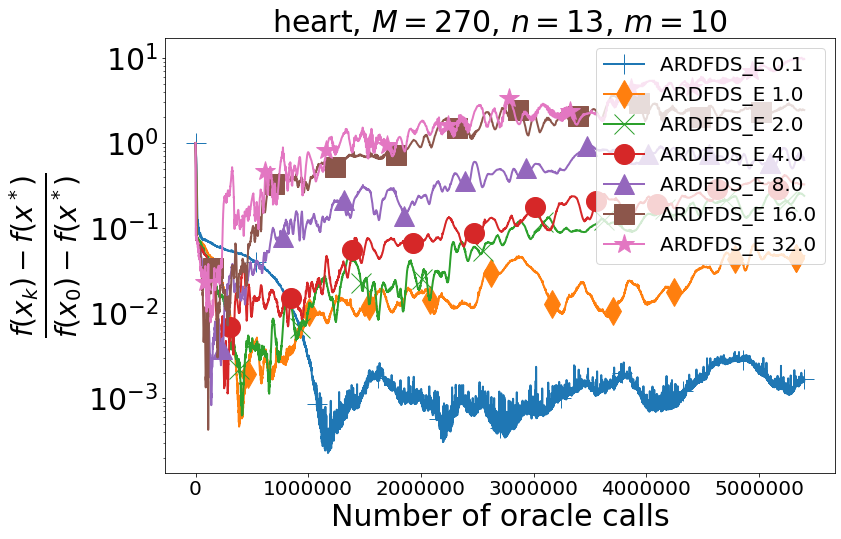

In [9]:
methods = [['ARDFDS_E logreg', [0.1, N, delta, bs], "ARDFDS_E "+str(0.1), None]]
tuning_stepsize_param_options_ardfds_e = [0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
    methods = np.vstack((methods, 
                         ['ARDFDS_E logreg', [tuning_stepsize_param_options_ardfds_e[i], N, delta, bs], 
                          "ARDFDS_E "+str(tuning_stepsize_param_options_ardfds_e[i]), None]))

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_ardfds_e_noise_tuning_stepsize_"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

### ARDFDS_NE

In [ ]:
%%time
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 100.0, 500.0, 1000.0, 2000.0]
for step_param in tuning_stepsize_param_options_ardfds_e:
    ardfds_e_res = ardfds_ne_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
                        f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

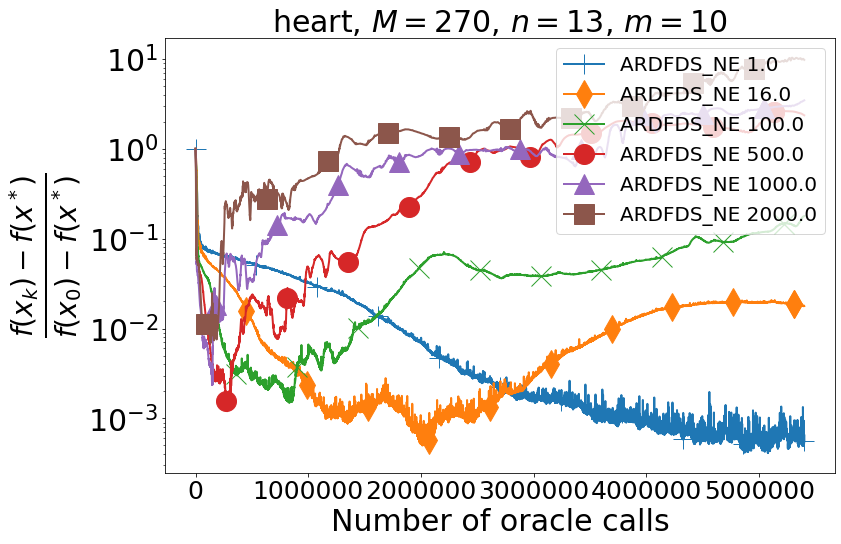

In [10]:
methods = [['ARDFDS_NE logreg', [1.0, N, delta, bs], "ARDFDS_NE "+str(1.0), None]]
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 100.0, 500.0, 1000.0, 2000.0]
for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
    methods = np.vstack((methods, 
                         ['ARDFDS_NE logreg', [tuning_stepsize_param_options_ardfds_e[i], N, delta, bs], 
                          "ARDFDS_NE "+str(tuning_stepsize_param_options_ardfds_e[i]), None]))

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_ardfds_ne_noise_tuning_stepsize_"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

### RDFDS_E

In [ ]:
%%time
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 32.0, 64.0, 128.0, 150.0, 175.0, 250.0, 300.0, 500.0, 1000.0]
for step_param in tuning_stepsize_param_options_ardfds_e:
    ardfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
                        f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

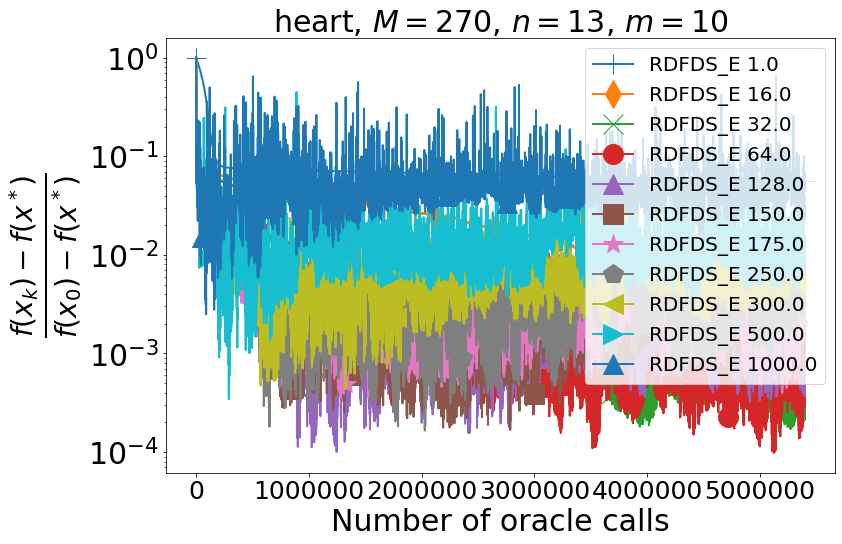

In [11]:
methods = [['RDFDS_E logreg', [1.0, N, delta, bs], "RDFDS_E "+str(1.0), None]]
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 32.0, 64.0, 128.0, 150.0, 175.0, 250.0, 300.0, 500.0, 1000.0]
for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
    methods = np.vstack((methods, 
                         ['RDFDS_E logreg', [tuning_stepsize_param_options_ardfds_e[i], N, delta, bs], 
                          "RDFDS_E "+str(tuning_stepsize_param_options_ardfds_e[i]), None]))

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_rdfds_e_noise_tuning_stepsize_"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

### RDFDS_NE

In [ ]:
%%time
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 100.0, 500.0, 1000.0, 2000.0, 10000.0, 15000.0, 20000.0]
for step_param in tuning_stepsize_param_options_ardfds_e:
    ardfds_e_res = rdfds_ne_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
                        f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

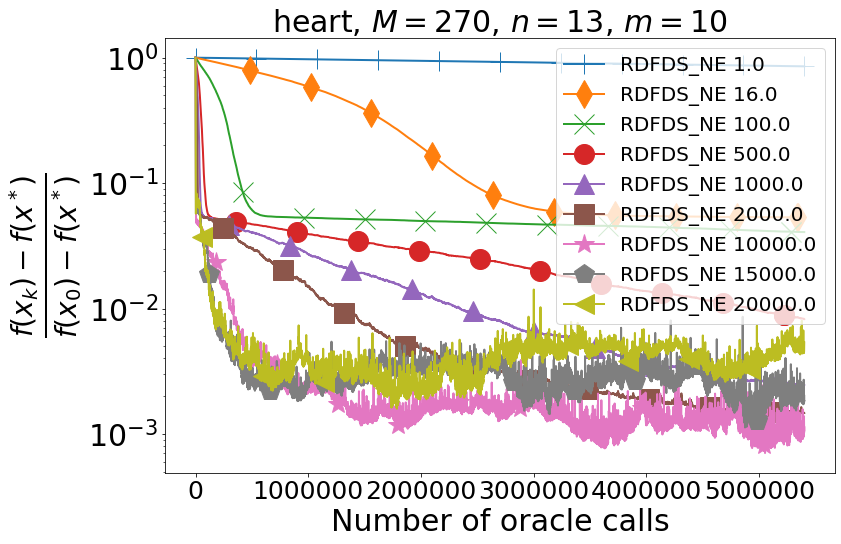

In [12]:
methods = [['RDFDS_NE logreg', [1.0, N, delta, bs], "RDFDS_NE "+str(1.0), None]]
tuning_stepsize_param_options_ardfds_e = [1.0, 16.0, 100.0, 500.0, 1000.0, 2000.0, 10000.0, 15000.0, 20000.0]
for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
    methods = np.vstack((methods, 
                         ['RDFDS_NE logreg', [tuning_stepsize_param_options_ardfds_e[i], N, delta, bs], 
                          "RDFDS_NE "+str(tuning_stepsize_param_options_ardfds_e[i]), None]))

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_rdfds_ne_noise_tuning_stepsize_"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

### RSGF

In [ ]:
%%time
initial_stepsizes = [1.0]
tuning_stepsizes = [1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]

for initial_stepsize in initial_stepsizes:
    for tuning_stepsize in tuning_stepsizes:
        res = rsgf_tune_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
                        f_star=f_star, x_star=x_star, initial_stepsize=initial_stepsize,tuning_stepsize=tuning_stepsize)
        print("Finished with ", tuning_stepsize)

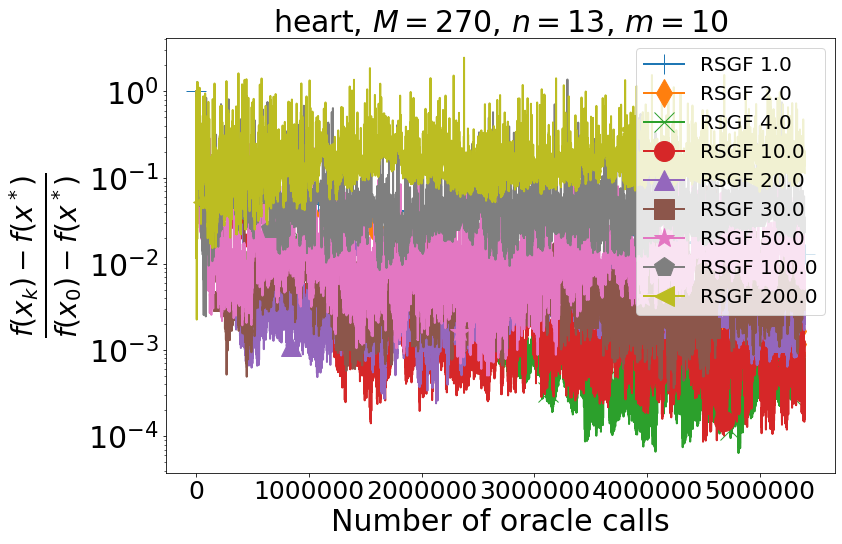

In [13]:
methods = [['RSGF logreg', [1.0, 1.0, N, delta, bs], "RSGF "+str(1.0), None]]
tuning_stepsize_param_options_ardfds_e = [1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]
for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
    methods = np.vstack((methods, 
                         ['RSGF logreg', [1.0, tuning_stepsize_param_options_ardfds_e[i], N, delta, bs], 
                          "RSGF "+str(tuning_stepsize_param_options_ardfds_e[i]), None]))

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_rsgf_noise_tuning_stepsize_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

### Comparison

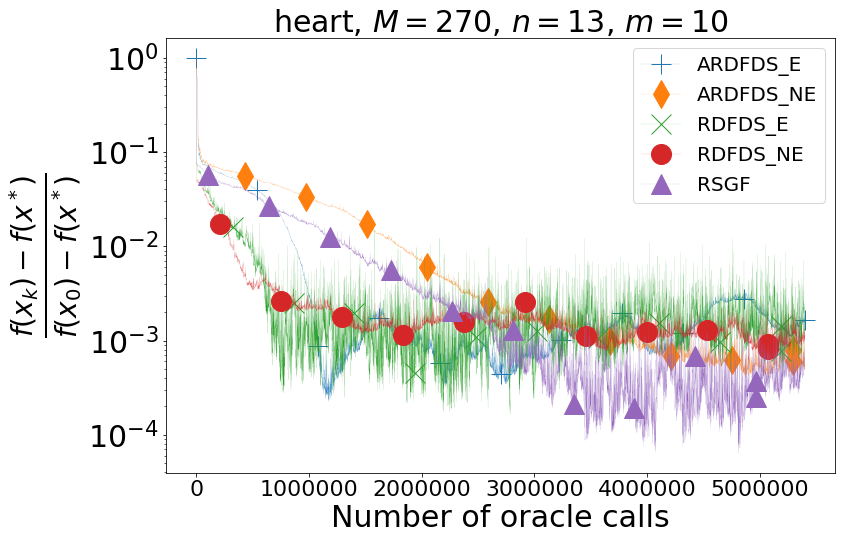

In [14]:
methods = [
    ['ARDFDS_E logreg', [0.1, N, delta, bs], "ARDFDS_E", None],
    ['ARDFDS_NE logreg', [1.0, N, delta, bs], "ARDFDS_NE", None],
    ['RDFDS_E logreg', [150.0, N, delta, bs], "RDFDS_E", None],
    ['RDFDS_NE logreg', [10000.0, N, delta, bs], "RDFDS_NE", None],
    ['RSGF logreg', [1.0, 4.0, N, delta, bs], "RSGF", None],
    ]

mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 0.1
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 22
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, filename+"_comparison_stoch_noise_delta_"+str(delta)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)